In [1]:
# Import libraries
# GoogleNews Documentation : https://pypi.org/project/GoogleNews/
from GoogleNews import GoogleNews
from newspaper import Article
from newspaper import Config
from tqdm import tqdm
import pandas as pd
import nltk  # NLP library
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import pyLDAvis.gensim_models
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
import warnings

warnings.filterwarnings('ignore')
sns.set()
pyLDAvis.enable_notebook()

In [2]:
# This tokenizer divides a text into a list of sentences by using an unsupervised algorithm to build a model for abbreviation words, collocations, and words that start sentences.
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/alfonso/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Config to avoid 403 forbidden error
user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
config = Config()
config.browser_user_agent = user_agent
config.request_timeout = 20

In [4]:
# Initializing
googlenews = GoogleNews()

In [5]:
# Clear previous search
googlenews.clear()

In [6]:
# Settings
googlenews = GoogleNews(lang='en',start='01/06/2023',end='01/06/2023')

In [7]:
# Search 
googlenews.search('Ukraine')
print(f"Articles found:", googlenews.total_count())

Articles found: 40700


In [8]:
# Results
result = googlenews.result()

In [9]:
# Convert to DataFrame
df = pd.DataFrame(result)
df.head(20)

,title,media,date,datetime,desc,link,img
0,,,,NaT,,https://support.google.com/websearch/answer/10...,
1,Ukraine: High Representative/Vice-President Jo...,EEAS,1 week ago,2023-01-10 19:45:04.230006,Ukraine: High Representative/Vice-President Jo...,https://www.eeas.europa.eu/eeas/ukraine-high-r...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
2,Ukraine war: Russians accused of opening fire ...,BBC,1 week ago,2023-01-10 19:45:04.253688,It said its forces had only returned fired dur...,https://www.bbc.com/news/world-europe-64187704,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
3,"Russia's war on Ukraine (UN, Ukraine governmen...",ReliefWeb,1 week ago,2023-01-10 19:45:04.269829,Ukraine rejected the Russian-proposed ceasefir...,https://reliefweb.int/report/ukraine/russias-w...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
4,More Than $3.75 Billion in U.S. Military Assis...,State Department,1 week ago,2023-01-10 19:45:04.289962,"In the longer term, this Foreign Military Fina...",https://www.state.gov/more-than-3-75-billion-i...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
5,Ukraine war: Western allies to send fighting v...,BBC,1 week ago,2023-01-10 19:45:04.313600,Germany and the US have agreed to join France ...,https://www.bbc.com/news/world-europe-64184430,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
6,Germany to Send Ukraine 40 Armored Vehicles by...,VOA,1 week ago,2023-01-10 19:45:04.334039,Germany will supply Ukraine with around 40 Mar...,https://www.voanews.com/a/germany-to-send-ukra...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
7,"Thanks To TikTok, Ukraine Is Raining Missile O...",EurAsian Times,1 week ago,2023-01-10 19:45:04.350754,Ukrainian forces have been precisely targeting...,https://eurasiantimes.com/thanks-to-tiktok-ukr...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
8,Ukraine under largest economic slump post-inde...,Helsinki Times,1 week ago,2023-01-10 19:45:04.365876,In the ongoing conflict between Ukraine and Ru...,https://www.helsinkitimes.fi/world-int/22772-u...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
9,Pope prays for Ukraine as Eastern Churches cel...,Vatican News,1 week ago,2023-01-10 19:45:04.383091,Pope Francis renews his prayers for peace in w...,https://www.vaticannews.va/en/pope/news/2023-0...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."


In [10]:
# Checking one article
df.iloc[8]['desc']

'In the ongoing conflict between Ukraine and Russia which has resulted in widespread devastation of life and property, Ukraine has suffered its sharpest...'

In [11]:
# Unfortunately there is a search limit on the number of news in this api. Maximum number is 10. Now, we will try to fetch more than that.
for i in tqdm(range(2,10), colour="red", desc="Getting news links from Google"):
  googlenews.getpage(i)
  result = googlenews.result()
  df = pd.DataFrame(result)

Getting news links from Google: 100%|██████████| 8/8 [00:16<00:00,  2.10s/it]


In [12]:
df.head(15)

,title,media,date,datetime,desc,link,img
0,,,,NaT,,https://support.google.com/websearch/answer/10...,
1,Ukraine: High Representative/Vice-President Jo...,EEAS,1 week ago,2023-01-10 19:45:04.230006,Ukraine: High Representative/Vice-President Jo...,https://www.eeas.europa.eu/eeas/ukraine-high-r...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
2,Ukraine war: Russians accused of opening fire ...,BBC,1 week ago,2023-01-10 19:45:04.253688,It said its forces had only returned fired dur...,https://www.bbc.com/news/world-europe-64187704,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
3,"Russia's war on Ukraine (UN, Ukraine governmen...",ReliefWeb,1 week ago,2023-01-10 19:45:04.269829,Ukraine rejected the Russian-proposed ceasefir...,https://reliefweb.int/report/ukraine/russias-w...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
4,More Than $3.75 Billion in U.S. Military Assis...,State Department,1 week ago,2023-01-10 19:45:04.289962,"In the longer term, this Foreign Military Fina...",https://www.state.gov/more-than-3-75-billion-i...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
5,Ukraine war: Western allies to send fighting v...,BBC,1 week ago,2023-01-10 19:45:04.313600,Germany and the US have agreed to join France ...,https://www.bbc.com/news/world-europe-64184430,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
6,Germany to Send Ukraine 40 Armored Vehicles by...,VOA,1 week ago,2023-01-10 19:45:04.334039,Germany will supply Ukraine with around 40 Mar...,https://www.voanews.com/a/germany-to-send-ukra...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
7,"Thanks To TikTok, Ukraine Is Raining Missile O...",EurAsian Times,1 week ago,2023-01-10 19:45:04.350754,Ukrainian forces have been precisely targeting...,https://eurasiantimes.com/thanks-to-tiktok-ukr...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
8,Ukraine under largest economic slump post-inde...,Helsinki Times,1 week ago,2023-01-10 19:45:04.365876,In the ongoing conflict between Ukraine and Ru...,https://www.helsinkitimes.fi/world-int/22772-u...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
9,Pope prays for Ukraine as Eastern Churches cel...,Vatican News,1 week ago,2023-01-10 19:45:04.383091,Pope Francis renews his prayers for peace in w...,https://www.vaticannews.va/en/pope/news/2023-0...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."


In [13]:
# Remove some weird rows
df = df[df['datetime'].notnull()]
df.head(15)

,title,media,date,datetime,desc,link,img
1,Ukraine: High Representative/Vice-President Jo...,EEAS,1 week ago,2023-01-10 19:45:04.230006,Ukraine: High Representative/Vice-President Jo...,https://www.eeas.europa.eu/eeas/ukraine-high-r...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
2,Ukraine war: Russians accused of opening fire ...,BBC,1 week ago,2023-01-10 19:45:04.253688,It said its forces had only returned fired dur...,https://www.bbc.com/news/world-europe-64187704,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
3,"Russia's war on Ukraine (UN, Ukraine governmen...",ReliefWeb,1 week ago,2023-01-10 19:45:04.269829,Ukraine rejected the Russian-proposed ceasefir...,https://reliefweb.int/report/ukraine/russias-w...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
4,More Than $3.75 Billion in U.S. Military Assis...,State Department,1 week ago,2023-01-10 19:45:04.289962,"In the longer term, this Foreign Military Fina...",https://www.state.gov/more-than-3-75-billion-i...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
5,Ukraine war: Western allies to send fighting v...,BBC,1 week ago,2023-01-10 19:45:04.313600,Germany and the US have agreed to join France ...,https://www.bbc.com/news/world-europe-64184430,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
6,Germany to Send Ukraine 40 Armored Vehicles by...,VOA,1 week ago,2023-01-10 19:45:04.334039,Germany will supply Ukraine with around 40 Mar...,https://www.voanews.com/a/germany-to-send-ukra...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
7,"Thanks To TikTok, Ukraine Is Raining Missile O...",EurAsian Times,1 week ago,2023-01-10 19:45:04.350754,Ukrainian forces have been precisely targeting...,https://eurasiantimes.com/thanks-to-tiktok-ukr...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
8,Ukraine under largest economic slump post-inde...,Helsinki Times,1 week ago,2023-01-10 19:45:04.365876,In the ongoing conflict between Ukraine and Ru...,https://www.helsinkitimes.fi/world-int/22772-u...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
9,Pope prays for Ukraine as Eastern Churches cel...,Vatican News,1 week ago,2023-01-10 19:45:04.383091,Pope Francis renews his prayers for peace in w...,https://www.vaticannews.va/en/pope/news/2023-0...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
10,"In the West, Putin Is Losing the Russia-Ukrain...",World Politics Review,1 week ago,2023-01-10 19:45:04.399112,Ukrainian President Volodymyr Zelenskyy receiv...,https://www.worldpoliticsreview.com/putin-russ...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."


In [14]:
# Get the full article extracting and parsing the article and drop the links that give problems

list = []

for ind in tqdm(df.index, colour="green", desc="Extracting articles from the internet"):
  dict = {}
  
  try:
    article = Article(df['link'][ind],config = config)
    article.download()
    article.parse()
    article.nlp()
    dict['Date'] = df['date'][ind]
    dict['Media'] = df['media'][ind]
    dict['Title'] = article.title
    dict['Article'] = article.text
    dict['Summary'] = article.summary
    list.append(dict)
  except Exception:
    df.drop([ind],axis=0,inplace=True)



Extracting articles from the internet: 100%|██████████| 90/90 [02:22<00:00,  1.58s/it]


In [15]:
# Create the news dataframe with full articles
news_df = pd.DataFrame(list)
news_df.head(20)

,Date,Media,Title,Article,Summary
0,1 week ago,EEAS,Ukraine: High Representative/Vice-President Jo...,Ukraine: High Representative/Vice-President Jo...,Ukraine: High Representative/Vice-President Jo...
1,1 week ago,BBC,Ukraine war: Russians accused of opening fire ...,"""We are two and a half hours into this proclai...","""We are two and a half hours into this proclai..."
2,1 week ago,ReliefWeb,"Russia’s war on Ukraine (UN, Ukraine governmen...",What are you looking for?\n\nSearch|t,What are you looking for?
3,1 week ago,State Department,More Than $3.75 Billion in U.S. Military Assis...,"In this first week of 2023, the United States ...",This assistance includes a $2.85 billion drawd...
4,1 week ago,BBC,Ukraine war: Western allies to send fighting v...,There was near-unanimous support for the Germa...,There was near-unanimous support for the Germa...
5,1 week ago,VOA,Germany to Send Ukraine 40 Armored Vehicles by...,Germany will supply Ukraine with around 40 Mar...,Germany will supply Ukraine with around 40 Mar...
6,1 week ago,EurAsian Times,"Thanks To TikTok, Ukraine Is Raining Missile O...",Ukrainian forces have been precisely targeting...,Ukrainian forces have been precisely targeting...
7,1 week ago,Vatican News,Pope prays for Ukraine as Eastern Churches cel...,Pope Francis renews his prayers for peace in w...,Pope Francis renews his prayers for peace in w...
8,1 week ago,World Politics Review,Why the War in Ukraine Hasn’t Polarized Wester...,"Or, now to get full access.\n\nWhat you’ll get...","Or, now to get full access.\nWhat you’ll get w..."
9,1 week ago,Reuters,Grid operator urges Ukrainians to save electri...,Summary\n\nSummary Companies Russia has been a...,Russian missile and drone attacks on energy in...


In [16]:
# Checking one article
news_df.iloc[8]['Article']

'Or, now to get full access.\n\nWhat you’ll get with an All-Access subscription to World Politics Review:\n\nA WPR subscription is like no other resource — it’s like having your own personal researcher and analyst for news and events around the globe. Subscribe now, and you’ll get:\n\nImmediate and instant access to the full searchable library of 15,000+ articles\n\nDaily articles with original analysis, written by leading topic experts, delivered to you every weekday\n\nWeekly in-depth reports on important issues and countries\n\nDaily links to must-read news, analysis, and opinion from top sources around the globe, curated by our keen-eyed team of editors\n\nYour choice of weekly region-specific newsletters, delivered to your inbox.\n\nSmartphone- and tablet-friendly website.\n\nCompletely ad-free reading.\n\nAnd all of this is available to you when you subscribe today.'

# Topic Modelling

In [17]:
#Running a model
nlp = en_core_web_md.load()

In [18]:
#Removing stopwords
removal= ['PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']

In [19]:
#Lemmatization & tokenization
tokens = []
for article in nlp.pipe(news_df['Article']):
	proj_tok = [token.lemma_.lower() for token in article if token.pos_ not in removal and not token.is_stop and token.is_alpha]
	tokens.append(proj_tok)

In [20]:
#Printing out tokens
news_df['tokens'] = tokens
news_df['tokens']

0     [ukraine, high, representative, vice, presiden...
1     [half, hour, proclaim, ceasefire, actually, te...
2                                                [look]
3     [week, united, states, continue, stand, strong...
4     [near, unanimous, support, german, head, bunde...
                            ...                        
76    [azerbaijan, enjoy, huge, boost, revenue, oil,...
77    [ukraine, important, litmus, test, western, ci...
78    [hour, time, immediate, start, require, remune...
79    [russian, reign, terror, continue, unabated, m...
80    [know, official, website, united, states, gove...
Name: tokens, Length: 81, dtype: object

In [21]:
#Creating a dictionary, giving each token a unique ID
dictionary = Dictionary(news_df['tokens'])
print(dictionary.token2id)

{'absence': 0, 'accountable': 1, 'action': 2, 'affairs': 3, 'aggression': 4, 'attack': 5, 'attempt': 6, 'attend': 7, 'barbaric': 8, 'border': 9, 'borrell': 10, 'building': 11, 'buy': 12, 'ceasefire': 13, 'change': 14, 'circumvention': 15, 'civilian': 16, 'commit': 17, 'concrete': 18, 'condemn': 19, 'constitute': 20, 'continue': 21, 'contradiction': 22, 'council': 23, 'counter': 24, 'crime': 25, 'critical': 26, 'declare': 27, 'defend': 28, 'deliberately': 29, 'destroy': 30, 'determination': 31, 'development': 32, 'discuss': 33, 'dmytro': 34, 'drone': 35, 'economic': 36, 'effective': 37, 'ensure': 38, 'entire': 39, 'equipment': 40, 'eu': 41, 'exercise': 42, 'facility': 43, 'fact': 44, 'follow': 45, 'foreign': 46, 'friday': 47, 'ground': 48, 'high': 49, 'hold': 50, 'humanitarian': 51, 'illegally': 52, 'implementation': 53, 'include': 54, 'indiscriminately': 55, 'infrastructure': 56, 'intensify': 57, 'international': 58, 'internationally': 59, 'involve': 60, 'january': 61, 'josep': 62, 'ki

In [22]:
#Filtering out low-frequency and high-frequency tokens, also limit the vocabulary to a max of 1000 words
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

In [23]:
#Creating a corpus
corpus = [dictionary.doc2bow(doc) for doc in news_df['tokens']]

In [24]:
#Building a model with LDA that represents topics as word probabilities and allows for uncovering latent or hidden topics as it clusters the words based on their co-occurrence in a respective document
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 4, passes=10)

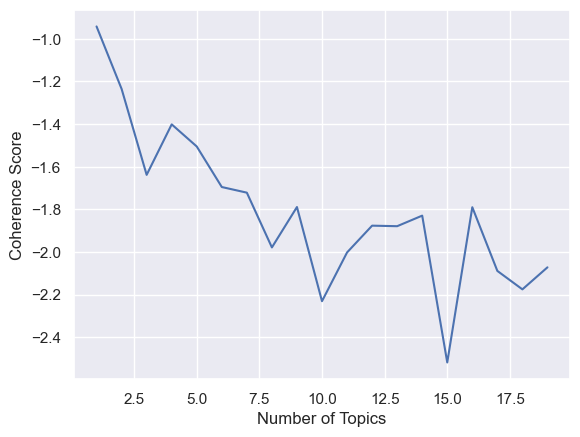

In [25]:
#Calculating the coherence score using C_umass to measure the degree of semantic similarity between high scoring words in each topic
topics = []
score = []
for i in range (1,20,1):   
  lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)   
  cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')   
  topics.append(i)
  score.append(cm.get_coherence())
plt.plot(topics, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

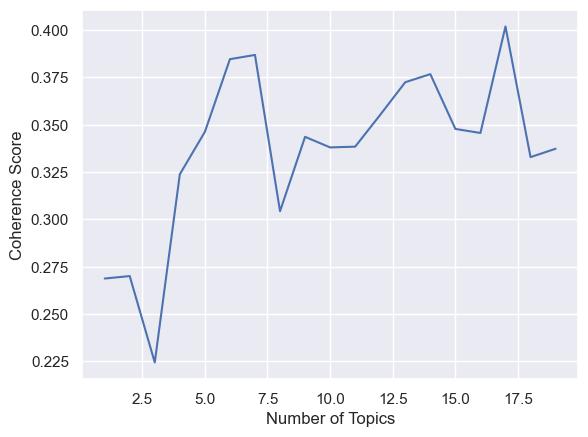

In [26]:
#Calculating the coherence score using C_v
topics = []
score = []
for i in range(1,20,1):  
  lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)   
  cm = CoherenceModel(model=lda_model, texts = news_df['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')   
  topics.append(i)
  score.append(cm.get_coherence())
plt.plot(topics, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

In [27]:
#Printing out the results
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=6, workers = 4, passes=100)
for top in lda_model.print_topics(10):
  print(top)

(0, '0.025*"refugee" + 0.016*"return" + 0.014*"include" + 0.013*"direct" + 0.012*"access" + 0.011*"video" + 0.010*"government" + 0.009*"local" + 0.009*"ensure" + 0.008*"french"')
(1, '0.017*"defense" + 0.016*"vehicle" + 0.016*"tank" + 0.014*"missile" + 0.014*"provide" + 0.012*"system" + 0.011*"military" + 0.010*"air" + 0.009*"kyiv" + 0.009*"include"')
(2, '0.016*"iran" + 0.015*"international" + 0.014*"party" + 0.012*"hold" + 0.012*"act" + 0.011*"world" + 0.011*"military" + 0.010*"united" + 0.010*"minister" + 0.010*"states"')
(3, '0.018*"work" + 0.014*"power" + 0.014*"december" + 0.011*"nuclear" + 0.011*"site" + 0.010*"team" + 0.010*"plant" + 0.010*"cause" + 0.009*"need" + 0.009*"facility"')
(4, '0.015*"putin" + 0.012*"moscow" + 0.012*"military" + 0.012*"force" + 0.012*"month" + 0.011*"new" + 0.010*"report" + 0.010*"attack" + 0.009*"accord" + 0.008*"food"')
(5, '0.013*"people" + 0.010*"house" + 0.009*"world" + 0.009*"aid" + 0.009*"new" + 0.009*"help" + 0.008*"soldier" + 0.008*"ukrainian

In [28]:
#Distribution of topics in a document
lda_model[corpus][0]

[(2, 0.99242353)]

In [29]:
#Visualization of topics
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

In [30]:
#Creating a new column for topics
news_df['topic'] = [sorted(lda_model[corpus][text])[0][0] for text in range(len(news_df['Article']))]

In [31]:
#Counting frequency of every topic in a document
news_df.topic.value_counts()

1    24
0    17
2    12
4    11
3    10
5     7
Name: topic, dtype: int64

In [32]:
news_df.head()

,Date,Media,Title,Article,Summary,tokens,topic
0,1 week ago,EEAS,Ukraine: High Representative/Vice-President Jo...,Ukraine: High Representative/Vice-President Jo...,Ukraine: High Representative/Vice-President Jo...,"[ukraine, high, representative, vice, presiden...",2
1,1 week ago,BBC,Ukraine war: Russians accused of opening fire ...,"""We are two and a half hours into this proclai...","""We are two and a half hours into this proclai...","[half, hour, proclaim, ceasefire, actually, te...",0
2,1 week ago,ReliefWeb,"Russia’s war on Ukraine (UN, Ukraine governmen...",What are you looking for?\n\nSearch|t,What are you looking for?,[look],0
3,1 week ago,State Department,More Than $3.75 Billion in U.S. Military Assis...,"In this first week of 2023, the United States ...",This assistance includes a $2.85 billion drawd...,"[week, united, states, continue, stand, strong...",1
4,1 week ago,BBC,Ukraine war: Western allies to send fighting v...,There was near-unanimous support for the Germa...,There was near-unanimous support for the Germa...,"[near, unanimous, support, german, head, bunde...",0
